# Обновление дизайна в мобильной игре

В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков).

Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу. Опишите оптимальный по вашему мнению дизайн эксперимента.

Рассчитайте длительность эксперимента при условии, что каждый день в игру приходит около 100 новых игроков.

Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте доверительный интервал.

Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, ДИ и ваши выводы для каждого варианта.

Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную методику расчета, алгоритм и т.д.

*Можно попробовать решить и с помощью бустрепа

## Подключаем библиотеки

In [310]:
from statsmodels.stats.proportion import proportion_effectsize, proportion_confint
from statsmodels.stats.power import zt_ind_solve_power
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Дизайн эксперимента

Итак, мы хотим проверить гипотезу, что месячная конверсия новых пользователей в нашем мобильном приложении 
в покупку увеличится с 10% до 11%. Для проверки этой гипотезы необходимо провести A/B тестирование.

Для начала опишем следующий дизайн A/B тестирования:

#### 1) Гипотеза
_Мы формулируем следующую гипотезу_:

__Обновление дизайна, позволит увеличить конверсию в покупку на 1 процентный пункт (с 10% до 11%) по экспертной оценке геймдизайнеров__.

#### 2) Метрики
_Метрики_:

В качестве основной метрики ($KPI$) будем рассматривать _конверсию_ из установки приложения в покупку в приложении.

#### 3) Формируем выборки
_Формируем тест и контроль_:

В идеале формировать экспериментальную и контрольную выборки стоит, основываясь на сегментации пользователей: провести различные тесты для пользователей с Android и IOS, для пользователей из различных регионов мира, для пользователей использующих приложение по выходным или по будням и т.д. Также технически можно было бы распределять некоторых пользователей одновременно в тестовые группы для разных сегментов (слоёв), чтобы слои были ортогональны (также в этом случае нам бы пришлось использовать соль для id пользователей). 

В общем, способов, как можно формировать тест и контроль очень много, но мы для начала проведём обычное тестирование для всех ($\approx 500$) пользователей. Причём делить их будем на тест и контроль _случайным образом_.

#### 4) Тест
_Тест и статистика_:

В качестве теста возьмём по сути z-тест в случае двух выборок из распределения бернулли. 

То есть в это случае: 
- У нас есть выборка A $(X_1, \ldots, X_{n_a}) \text{ с } m_a \text{ - количеством успехов}$
и выборка B $(Y_1, \ldots, Y_{n_b}) \text{ с } m_b \text{ - количеством успехов}$
- Проверяем гипотезу о средних (одностороннюю): $$ H_0: p_a = p_b, \quad H_1: p_b > p_a$$
- Мы считаем средние (то есть частоты успехов) $w_a = \frac{m_a}{n_a}, w_b = \frac{m_b}{n_b}, w = \frac{m_a + m_b}{n_a + n_b}$
- В итоге считаем статистику: $$U = \frac{w_b - w_a}{\sqrt{w * (1 - w) * (\frac{1}{n_a} + \frac{1}{n_b}) }}$$

Напишем реализацию нашего теста на python:

In [311]:
def test(ma, na, mb, nb, alpha, alternative="two-sided"):
    '''
    output:
    False - H_0 принимается 
    True - H_0 отвергается 
    '''
    wa = ma / na
    wb = mb / nb
    w = (ma + mb) / (na + nb)
    diff = wb - wa
    stat = (diff) / np.sqrt(w * (1 - w) * (1. / na + 1. / nb))
    # 
    dist_norm = stats.norm(loc=0, scale=1)
    # 
    SE = np.sqrt(w * (1-w) * (1/na + 1/nb))
    quantile = dist_norm.ppf(alpha/2)
    CI = (diff + SE * quantile, diff - SE * quantile)
    # 
    if alternative == "two-sided":
        p_value = 2 * min(dist_norm.sf(stat), dist_norm.cdf(stat))
        if p_value > alpha:
            return False, CI
        return True, CI
    elif alternative == "greater":
        p_value = dist_norm.sf(stat)
        if p_value > alpha:
            return False, CI
        return True, CI
    elif alternative == "less":
        p_value = dist_norm.cdf(stat)
        if p_value > alpha:
            return False, CI
        return True, CI
    return None, CI

#### 5) Параметры теста
_Параметры теста и время теста_:

В качестве статистической значимости теста мы возьмём стандартную $\alpha = 5\%$, при этом мы хотим $MDE = 1\%$, так как мы хотим задетектировать эффект в 1 процентный пункт, а также ошибку 2 рода $\beta = 20 \%$. Рассчитаем размер выборки в этом нашем случае:

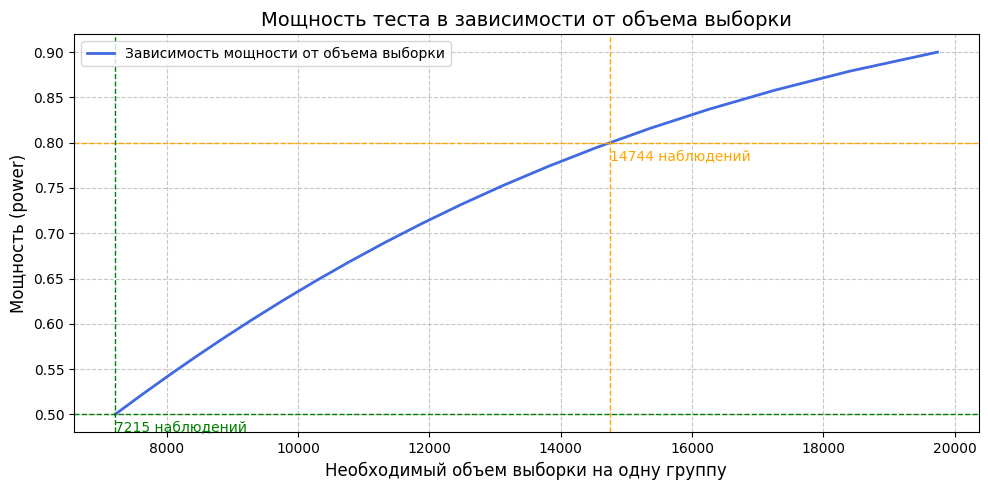

Оценка количества дней для двух групп для мощности в 50 %: 2 * 7215 / 100 = 144 дней
Оценка количества дней для двух групп для мощности в 80 %: 2 * 14744 / 100 = 294 дней


In [312]:
# Параметры
alpha = 0.05
beta = 0.2
power_range = np.linspace(0.5, 0.9, 20)
effect_size = proportion_effectsize(0.1, 0.11)

# Расчёт объема выборки для различных значений мощности
sample_sizes = [zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=p, ratio=1) for p in power_range]

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, power_range, label="Зависимость мощности от объема выборки", color="royalblue", linewidth=2)

# Отметка для мощности 0.8
target_power_80 = 0.8
sample_80 = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=target_power_80, ratio=1)
plt.axhline(y=target_power_80, color="orange", linestyle="--", linewidth=1)
plt.axvline(x=sample_80, color="orange", linestyle="--", linewidth=1)
plt.text(sample_80 + 1, target_power_80 - 0.02, f"{int(sample_80)} наблюдений", color="orange")

# Отметка для мощности 0.5
target_power_50 = 0.5
sample_50 = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=target_power_50, ratio=1)
plt.axhline(y=target_power_50, color="green", linestyle="--", linewidth=1)
plt.axvline(x=sample_50, color="green", linestyle="--", linewidth=1)
plt.text(sample_50 + 1, target_power_50 - 0.02, f"{int(sample_50)} наблюдений", color="green")

# Оформление графика
plt.title("Мощность теста в зависимости от объема выборки", fontsize=14)
plt.xlabel("Необходимый объем выборки на одну группу", fontsize=12)
plt.ylabel("Мощность (power)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Вывод результата
print(f"Оценка количества дней для двух групп для мощности в 50 %: 2 * {int(sample_50)} / 100 = {int(2 * sample_50 / 100)} дней")
print(f"Оценка количества дней для двух групп для мощности в 80 %: 2 * {int(sample_80)} / 100 = {int(2 * sample_80 / 100)} дней")

Итак, видно, что для достижения мощности в 80 % (чтобы обнаружить эффект в 1%) потребуется потратить на эксперимент больше 9 месяцев (при условии, 
что ежедневный трафик новых пользователей составляет 100 человек в день), что слишком много для тестирования. 
Причём для подобного эксперимента могут возникнуть проблемы, связанные с сезонностью трафика.
Также для проведения теста с мощностью в 50 % понадобится примерно 5 месяцев!

Обычно, чтобы улучшить чувствительность, используют некоторые из следующих методов:
- _стратифицированный анализ_ (будем группировать пользователей по источнику трафика, устройству и т.п.), таким образом мы, конечно, должны переформулировать нашу гипотезу для разных сегментов, но при таком анализе, мы уменьшаем дисперсию в стратах, что позволяет повысить нам чувствительность теста.
- использовать _ковариационную корректировку_, например, через CUPED, то есть вычесть из метрики величины, рассчитанную на основе исторических данных.
- просто увеличить трафик на направление / объединить несколько доменов или страниц с одинаковым поведением
- _сменить метрику на более чувствительную_ прокси-метрику: смотреть на клики, добавления в корзину, глубину просмотра, время на сайте, engagement score, если релевантно. Так как такие метрики обычно менее дискретные и быстрее “подхватывают” изменения.

Мы же продолжим проводить наше тестирование.

#### 6) Проверка теста
Перед запуском теста проведём проверочные запуски на различных синтетических данных нашего теста, чтобы проверить его значимость.

Но для начала сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитаем 95% доверительный интервал для него.

In [324]:
n = 14744
p_0 = 0.1
binom0_sample = stats.binom.rvs(n, p_0)

print(f"количество плательщиков = {binom0_sample}")

L_0, R_0 = proportion_confint(count=binom0_sample, nobs=n, alpha=.1, method="wilson")
print(f"95% доверительный интервал = [{L_0}, {R_0}]")

количество плательщиков = 1481
95% доверительный интервал = [0.09644870601202082, 0.10459318329118675]


Теперь же сгенерируем несколько вариантов экспериментальной группы 
- хуже: конверсия = 9%,
- лучше: конверсия = 12 %,
- без эффекта: конверсия равна = 10.5%

И рассчитаем силу эффекта и доверительный интервал

In [330]:
p_less = .09
p_greater = .12
p_equal = .105

binom0_sample = st.binom.rvs(n, p_0)
binom_sample_less = st.binom.rvs(n, p_less)
binom_sample_greater = st.binom.rvs(n, p_greater)
binom_sample_equal = st.binom.rvs(n, p_equal)

effect_less = proportion_effectsize(p_0, p_less)
effect_greater = proportion_effectsize(p_0, p_greater)
effect_equal = proportion_effectsize(p_0, p_equal)

print(f"размеры эффекта для группы хуже, лучше и без эффекта равны = {effect_less}, {effect_greater}, {effect_equal}")

L_less, R_less = proportion_confint(count=binom_sample_less, nobs=n, alpha=.1, method="wilson")
print(f"95% доверительный интервал для группы с худшим эффектом = [{L_less:.4}, {R_less:.4}]")

L_greater, R_greater = proportion_confint(count=binom_sample_greater, nobs=n, alpha=.1, method="wilson")
print(f"95% доверительный интервал для группы с лучшим эффектом = [{L_greater:.4}, {R_greater:.4}]")

L_equal, R_equal = proportion_confint(count=binom_sample_equal, nobs=n, alpha=.1, method="wilson")
print(f"95% доверительный интервал для группы без эффекта = [{L_equal:.4}, {R_equal:.4}]")

размеры эффекта для группы хуже, лучше и без эффекта равны = 0.03411580076248932, -0.06398210298605855, -0.016486220594214007
95% доверительный интервал для группы с худшим эффектом = [0.088, 0.09582]
95% доверительный интервал для группы с лучшим эффектом = [0.112, 0.1207]
95% доверительный интервал для группы без эффекта = [0.1016, 0.11]


Теперь же используем метод Монте-Карло, который проверяет, как часто тест ошибается при заданных. 
То есть он по истинным вероятностям выборок 
$p_{binom0} \text{ и } p_{binom1}$ выдаст оценку для ошибки 1 рода, если $p_{binom0} >= p_{binom1}$, 
и ошибки 2 рода, если $p_{binom0} < p_{binom1}$

In [336]:
def monte_carlo(N_experiments, p_binom0, p_binom1, n0, alpha, h0_true=True, ratio = 1., alternative="greater"):
    '''
    Для теста (def test(...))
    выдаёт ошибку:
    - 1 рода - если истинный p_binom0 >= p_binom1
    - 2 рода - если истинный p_binom0 < p_binom1
    '''
    # h0_true = p_binom0 >= p_binom1
    n1 = int(ratio * n0)
    bad_cnt = 0.
    for elem in range(N_experiments):
        binom0_sample = st.binom.rvs(n0, p_binom0)
        binom1_sample = st.binom.rvs(n1, p_binom1)
        test_ret, _ = test(binom0_sample, n0, binom1_sample, n1, alpha, alternative=alternative)
        if h0_true and test_ret:
            bad_cnt += 1             
        if not h0_true and not test_ret:
            bad_cnt += 1
    return bad_cnt / N_experiments

In [332]:
N_experiments = 10000

In [337]:
mc_less = monte_carlo(N_experiments, p_0, p_less, n, alpha, True)
L, R = proportion_confint(count=mc_less * N_experiments, nobs=N_experiments, alpha=.1, method="wilson")
L, R

(0.0, 0.0002704811655548492)

In [338]:
mc_greater = monte_carlo(N_experiments, p_0, p_greater, n, alpha, False)
L, R = proportion_confint(count=mc_greater * N_experiments, nobs=N_experiments, alpha=.1, method="wilson")
L, R

(6.61868582759022e-05, 0.0006041861148127251)

In [340]:
mc_equal = monte_carlo(N_experiments, p_0, p_equal, n, alpha, False)
L, R = proportion_confint(count= mc_equal * N_experiments, nobs=N_experiments, alpha=.1, method="wilson")
L, R

(0.5829898091804776, 0.5991609091511582)

По итогу, видно, что для нашего размера выборок оценки 1 рода для группы с худшим эффектом 
сильно меньше $\alpha$ и ошибка 2 рода для группы с лучшим эффектом около нулевая. Но вот ошибка 2 рода для группы с конверсией 10.5 % лежит в диапазоне от 58.2 % до 59.9 %. Однако в любом случае можно сказать, что наш тест 
работает корректно на группах с худшим эффектом, лучшим эффектом и на группе практически без эффекта.

#### 7) Запуск теста и проверка результатов.

_Дальше проводим запуск теста_, а после его завершения проводим оценку результатов.

#### 8) Масштабирование эффекта.

В случае успешного теста, необходимо выкатить обновление в прод и при этом продолжить исследование уже на реальных данных. 

#### \* Дополнение:

Можно было бы вместо z-теста использовать бутстрап, но он вычислительно сложнее

Средняя разница: 0.0146
Доверительный интервал: [0.0075, 0.0218]


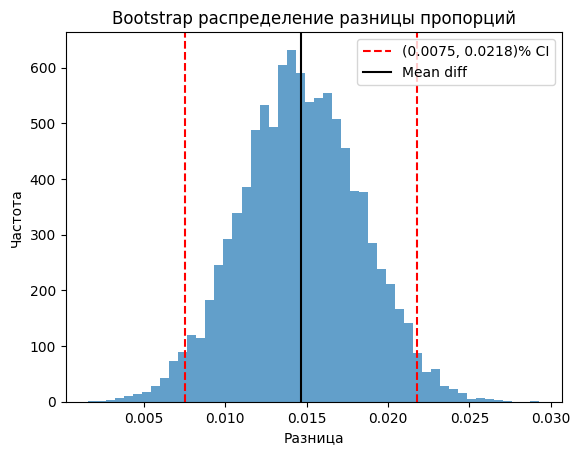

In [345]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_proportion_diff(control, test, n_bootstrap=10000, ci=95):
    diffs = []
    size = min(len(control), len(test))
    for _ in range(n_bootstrap):
        sample_control = np.random.choice(control, size=size, replace=True)
        sample_test = np.random.choice(test, size=size, replace=True)
        diff = sample_test.mean() - sample_control.mean()
        diffs.append(diff)

    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return np.mean(diffs), (lower, upper), diffs

# Пример данных
control = np.random.binomial(1, 0.10, 14000)
test = np.random.binomial(1, 0.11, 14000)

# Bootstrap-анализ
mean_diff, (ci_low, ci_high), diffs = bootstrap_proportion_diff(control, test)
ci = (ci_low, ci_high)
print(f"Средняя разница: {mean_diff:.4f}")
print(f"Доверительный интервал: [{ci_low:.4f}, {ci_high:.4f}]")

# Визуализация
plt.hist(diffs, bins=50, alpha=0.7)
plt.axvline(ci_low, color='red', linestyle='--', label=f"({ci_low:.4f}, {ci_high:.4f})% CI")
plt.axvline(ci_high, color='red', linestyle='--')
plt.axvline(mean_diff, color='black', label='Mean diff')
plt.legend()
plt.title("Bootstrap распределение разницы пропорций")
plt.xlabel("Разница")
plt.ylabel("Частота")
plt.show()


Напишем функцию самого теста и метода монте-карло для него

In [287]:
def bootstrap_test(control, test, alpha, n_bootstrap):
    _, CI, _ = bootstrap_proportion_diff(control, test, n_bootstrap=n_bootstrap, ci=100 - 100 * alpha)
    if max(CI) > 0 and min(CI) < 0:
        return False, CI
    return True, CI

In [303]:
def bootstrap_monte_carlo(N_experiments, n_bootstrap, p_binom0, p_binom1, n0, alpha, ratio = 1.):
    '''
    Для теста (def test(...))
    выдаёт ошибку:
    - 1 рода - если истинный p_binom0 >= p_binom1
    - 2 рода - если истинный p_binom0 < p_binom1
    '''
    h0_true = p_binom0 >= p_binom1
    n1 = int(ratio * n0)
    bad_cnt = 0.
    for elem in range(N_experiments):
        binom0_sample = st.binom.rvs(1, p_binom0, size=n0)
        binom1_sample = st.binom.rvs(1, p_binom1, size=n1)
        test_ret, _ = bootstrap_test(binom0_sample, binom1_sample, alpha, n_bootstrap)
        if h0_true and test_ret:
            bad_cnt += 1             
        if not h0_true and not test_ret:
            bad_cnt += 1
    return bad_cnt / N_experiments

In [346]:
n_bootstrap = 1000
N_experiments = 1000
# 
bootstrap_mc_less = bootstrap_monte_carlo(N_experiments, n_bootstrap, p_0, p_less, 1000, alpha, ratio = 1.)
L, R = proportion_confint(count=bootstrap_mc_less * N_experiments, nobs=N_experiments, alpha=.1, method="wilson")
L, R

(0.1088030011321795, 0.14322068129764087)

Ошибка 1 рода слишком велика, для её уменьшения надо увеличить размер выборки, что приведёт к ещё дольшему времени работы метода монте-карло.